## Trabalho Prático 2 - Planejamento e Navegação

Utilizando a estratégia de planejamento de caminhos Roadmap, deve-se utilizar um robô Holonômico.

As carcterísticas de um robô holonômico são: 
- Possuem um número de velocidades atuáveis 

#### Instalando pacotes não habituais utilizados no código

In [145]:
#pip install coppeliasim-zmqremoteapi-client

#!pip install pyvisgraph
!pip install opencv-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 1.7 MB/s eta 0:00:23
   ---------------------------------------- 0.3/38.8 MB 4.3 MB/s eta 0:00:09
    --------------------------------------- 0.8/38.8 MB 6.0 MB/s eta 0:00:07
   - -------------------------------------- 1.2/38.8 MB 6.6 MB/s eta 0:00:06
   - -------------------------------------- 1.6/38.8 MB 7.3 MB/s eta 0:00:06
   -- ------------------------------------- 2.1/38.8 MB 7.7 MB/s eta 0:00:05
   -- ------------------------------------- 2.5/38.8 MB 7.7 MB/s eta 0:00:05
   --- ------------------------------------ 3.0/38.8 MB 8.3 MB/s eta 0:00:05
   --- ------------------------------------ 3.5/38.8 MB 8.2 MB/s eta 0:00:05
   ---- ----------------------------------- 3.9/38.8 MB 8.7 MB/s eta 0:00:05
   ---- ----------------------------------- 4.4/38.8 MB 8.7 MB/s eta 0:00:04
   ---- ----------------------------------- 4.8/38.8 MB 8.6 MB/s eta 0:00:04
   ---

### Importando as bibliotecas

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import networkx as nx
from coppeliasim_zmqremoteapi_client import *
import random

import pyvisgraph as vg
from pyvisgraph.visible_vertices import edge_distance
import matplotlib.pyplot as plt
from graph import DiGraph
from algorithms import dijkstra
import homotopy as h

### Remote API functions (Python)

Criação do cliente para conexão com a api remota

Link para repositório da SimZMQRemoteApi: https://github.com/CoppeliaRobotics/zmqRemoteApi/tree/master/clients/python

In [22]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
robotino = sim.getObject('/robotino')
print("Printando o robotininho: " + str(robotino))

Printando o robotininho: 13


### Funções auxiliares

In [23]:
# Função para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

#### Carregando imagem do mapa

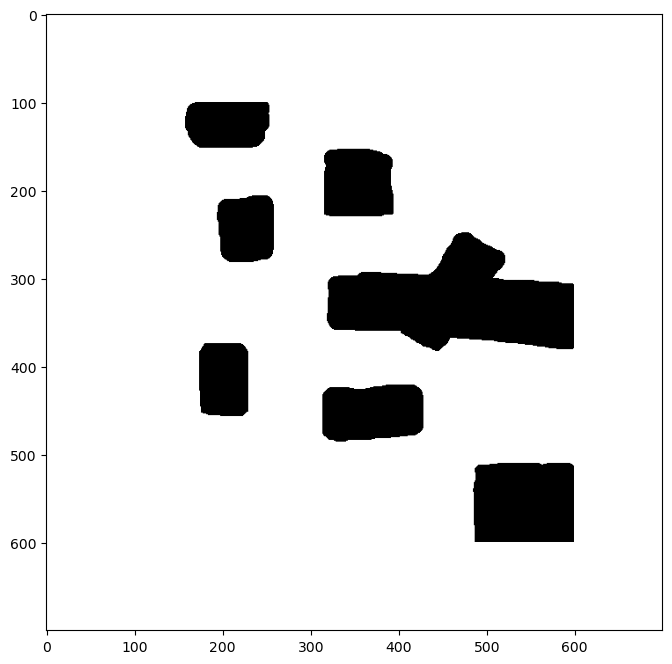

In [24]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('cave.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

#### Criando o grid com as células binarizadas

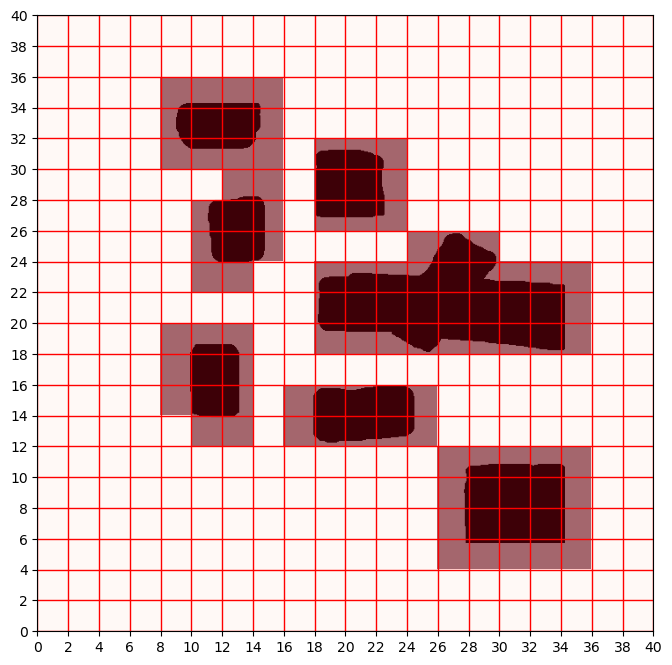

In [161]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([40, 40]) # Cave 

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

### Criando o Grafo para o Grid feito

In [188]:

def draw(polys, centers=[]):
	# Draw the obstacles
	for i in range(0, len(polys)):
		for j in range(0,len(polys[i])-1):
			plt.plot([polys[i][j].x, polys[i][j+1].x], [polys[i][j].y, polys[i][j+1].y], 'b')
		plt.plot([polys[i][0].x, polys[i][len(polys[i])-1].x], [polys[i][0].y, polys[i][len(polys[i])-1].y], 'b')
		if centers:	
			plt.plot(centers[i][0].x, centers[i][0].y, 'ko')
			plt.plot([centers[i][0].x, centers[i][0].x], [centers[i][0].y, centers[i][0].y+100], 'k:')
			plt.text(centers[i][0].x+0.3, centers[i][0].y, str(centers[i][1]))
	plt.axis('equal')
	#plt.axis([-20, 20,-20, 20])
	plt.xlabel("x (m)")
	plt.ylabel("y (m)")


In [210]:
# Função para verificar se uma célula é um contorno
def is_contour_cell(r, c, grid):
    if grid[r][c] == 1:
        # Verificar se há pelo menos um vizinho livre (0)
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and grid[nr][nc] == 0:
                return True
    return False

# Função para adicionar pontos do contorno ao array polys
def add_contour_points(r, c, polys):
    # Coordenadas das arestas da célula (c, r)
    top_left = vg.Point(c * cell_size, map_dims[0] - r * cell_size)
    bottom_left = vg.Point(c * cell_size, map_dims[0] - (r + 1) * cell_size)
    bottom_right = vg.Point((c + 1) * cell_size, map_dims[0] - (r + 1) * cell_size)
    top_right = vg.Point((c + 1) * cell_size, map_dims[0] - r * cell_size)

    # Adicionar pontos de contorno
    if r == 0 or grid[r-1][c] == 0:  # Aresta superior
        polys.append(top_left)
        polys.append(top_right)
    if r == rows-1 or grid[r+1][c] == 0:  # Aresta inferior
        polys.append(bottom_right)
        polys.append(bottom_left)
    if c == 0 or grid[r][c-1] == 0:  # Aresta esquerda
        polys.append(bottom_left)
        polys.append(top_left)
    if c == cols-1 or grid[r][c+1] == 0:  # Aresta direita
        polys.append(top_right)
        polys.append(bottom_right)
        
def find_polygons(edges):
    polys = []
    while edges:
        polygon = []
        start_edge = edges.pop(0)
        current_point = start_edge[0]
        polygon.append(current_point)

        while True:
            # Find the next edge
            for edge in edges:
                if edge[0] == current_point:
                    next_point = edge[1]
                    break
                elif edge[1] == current_point:
                    next_point = edge[0]
                    break
            else:
                # No matching edge found, end of polygon
                break
            
            polygon.append(next_point)
            edges.remove(edge)
            current_point = next_point

            # Check if we have returned to the start point
            if current_point == start_edge[0]:
                break
        
        polys.append(polygon)
    return polys

Polígonos dos obstáculos:
['(4.00, 18.00)', '(5.00, 18.00)', '(5.00, 17.00)', '(4.00, 17.00)', '(5.00, 18.00)', '(6.00, 18.00)', '(6.00, 17.00)', '(5.00, 17.00)', '(6.00, 18.00)', '(7.00, 18.00)', '(7.00, 17.00)', '(6.00, 17.00)', '(7.00, 18.00)', '(8.00, 18.00)', '(8.00, 17.00)', '(7.00, 17.00)', '(7.00, 17.00)', '(8.00, 17.00)', '(8.00, 16.00)', '(7.00, 16.00)', '(7.00, 16.00)', '(8.00, 16.00)', '(8.00, 15.00)', '(7.00, 15.00)', '(7.00, 15.00)', '(8.00, 15.00)', '(8.00, 14.00)', '(7.00, 14.00)', '(7.00, 14.00)', '(8.00, 14.00)', '(8.00, 13.00)', '(7.00, 13.00)', '(7.00, 13.00)', '(8.00, 13.00)', '(8.00, 12.00)', '(7.00, 12.00)']
['(4.00, 17.00)', '(5.00, 17.00)', '(5.00, 16.00)', '(4.00, 16.00)', '(4.00, 18.00)', '(5.00, 18.00)', '(5.00, 17.00)', '(4.00, 17.00)', '(5.00, 18.00)', '(6.00, 18.00)', '(6.00, 17.00)', '(5.00, 17.00)', '(6.00, 18.00)', '(7.00, 18.00)', '(7.00, 17.00)', '(6.00, 17.00)', '(7.00, 18.00)', '(8.00, 18.00)', '(8.00, 17.00)', '(7.00, 17.00)', '(7.00, 17.00)', '(8

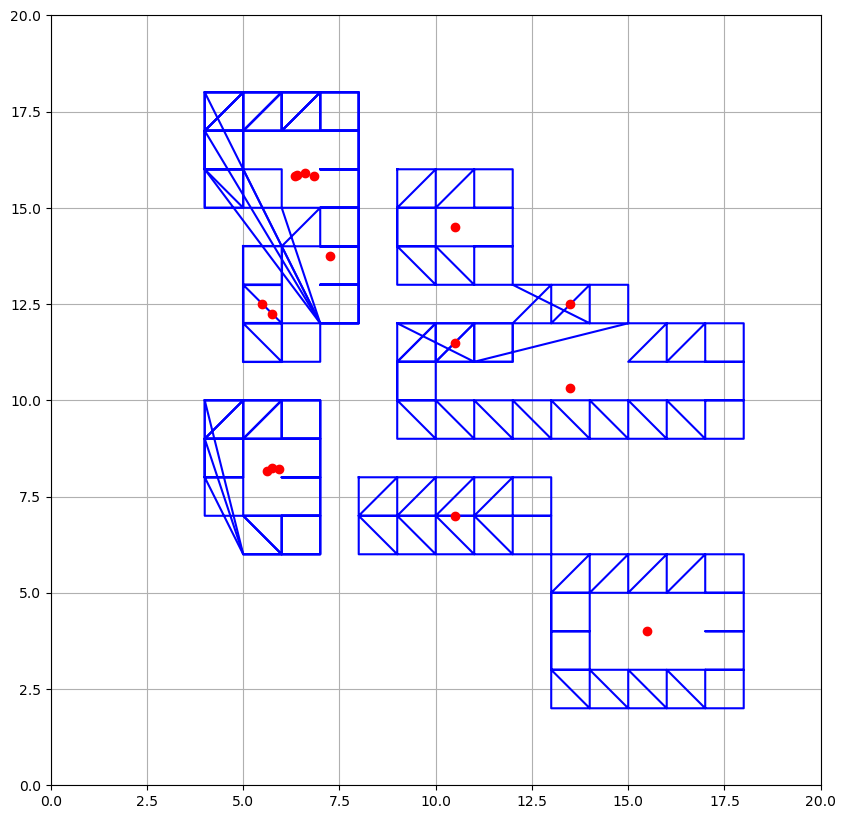

In [208]:
import networkx as nx
# Direções para vizinhos (em sentido horário começando do norte)
DIRECTIONS = [(-1, 0), (0, 1), (1, 0), (0, -1)]

# Suponha que grid é uma matriz numpy e vg.Point é uma classe de ponto
# Função para verificar se uma célula é um contorno
def is_contour_cell(r, c, grid):
    if grid[r][c] == 1:
        # Verifica se há pelo menos um vizinho livre
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < grid.shape[0] and 0 <= nc < grid.shape[1] and grid[nr][nc] == 0:
                return True
    return False

# Função para rastrear um contorno a partir de um ponto inicial
def trace_contour(grid, start_r, start_c):
    r, c = start_r, start_c
    contour = []
    visited = set()

    # Inicializar direção (começar indo para a direita)
    direction = 0

    while (r, c) not in visited:
        visited.add((r, c))
        contour.append((r, c))

        for i in range(len(DIRECTIONS)):
            # Tentar mover na direção atual
            dr, dc = DIRECTIONS[direction]
            nr, nc = r + dr, c + dc

            if is_contour_cell(nr, nc, grid):
                r, c = nr, nc
                break

            # Se não conseguir, tentar a próxima direção
            direction = (direction + 1) % len(DIRECTIONS)

        # Voltar ao início do contorno, parar
        if (r, c) == (start_r, start_c):
            break

    return contour

# Função para obter os pontos reais dos vértices de uma célula
def get_cell_vertices(r, c, cell_size):
    return [
        vg.Point(c * cell_size, map_dims[0] - r * cell_size),          # Bottom-left
        vg.Point((c + 1) * cell_size, map_dims[0] - r * cell_size),    # Bottom-right
        vg.Point((c + 1) * cell_size, map_dims[0] - (r + 1) * cell_size), # Top-right
        vg.Point(c * cell_size, map_dims[0] - (r + 1) * cell_size)     # Top-left
    ]

# Função para calcular o centro de um polígono dado pelos pontos
def calculate_centroid(polygon):
    x_coords = [p.x for p in polygon]
    y_coords = [p.y for p in polygon]
    centroid_x = sum(x_coords) / len(polygon)
    centroid_y = sum(y_coords) / len(polygon)
    return vg.Point(centroid_x, centroid_y)

# Dimensões e tamanho das células
map_dims = (grid.shape[0], grid.shape[1])
cell_size = 1

# Lista para armazenar os polígonos dos contornos
separate_polys = []

# Lista para manter controle das células visitadas
visited = np.zeros_like(grid)

# Rastrear todos os contornos no grid
for r in range(grid.shape[0]):
    for c in range(grid.shape[1]):
        if is_contour_cell(r, c, grid) and visited[r][c] == 0:
            contour = trace_contour(grid, r, c)
            # Marcar as células de contorno como visitadas
            for cr, cc in contour:
                visited[cr][cc] = 1
            # Converter as coordenadas da célula para pontos reais
            polygon = []
            for cr, cc in contour:
                polygon.extend(get_cell_vertices(cr, cc, cell_size))
            separate_polys.append(polygon)

# Calcular os centros dos polígonos
centers = [calculate_centroid(poly) for poly in separate_polys]

# Exibir os resultados
print("Polígonos dos obstáculos:")
for poly in separate_polys:
    print([str(p) for p in poly])

print("\nCentros dos obstáculos:")
for center in centers:
    print(f"({center.x}, {center.y})")

# Plotar os obstáculos e seus centros
plt.figure(figsize=(10, 10))
for poly in separate_polys:
    x = [p.x for p in poly] + [poly[0].x]  # Fechar o polígono
    y = [p.y for p in poly] + [poly[0].y]
    plt.plot(x, y, 'b-')
    
for center in centers:
    plt.plot(center.x, center.y, 'ro')  # Centros dos polígonos

plt.xlim(0, map_dims[1])
plt.ylim(0, map_dims[0])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()


[Point(4.00, 18.00), Point(4.00, 17.00), Point(4.00, 16.00), Point(4.00, 15.00), Point(5.00, 15.00), Point(6.00, 15.00), Point(6.00, 14.00), Point(5.00, 14.00), Point(5.00, 13.00), Point(5.00, 12.00), Point(5.00, 11.00), Point(6.00, 11.00), Point(7.00, 11.00), Point(7.00, 12.00), Point(8.00, 12.00), Point(8.00, 13.00), Point(8.00, 14.00), Point(8.00, 15.00), Point(8.00, 16.00), Point(8.00, 17.00), Point(8.00, 18.00), Point(7.00, 18.00), Point(6.00, 18.00), Point(5.00, 18.00)]
[Point(9.00, 16.00), Point(9.00, 15.00), Point(9.00, 14.00), Point(9.00, 13.00), Point(10.00, 13.00), Point(11.00, 13.00), Point(12.00, 13.00), Point(12.00, 14.00), Point(12.00, 15.00), Point(12.00, 16.00), Point(11.00, 16.00), Point(10.00, 16.00)]
[Point(12.00, 13.00), Point(12.00, 12.00), Point(11.00, 12.00), Point(10.00, 12.00), Point(9.00, 12.00), Point(9.00, 11.00), Point(9.00, 10.00), Point(9.00, 9.00), Point(10.00, 9.00), Point(11.00, 9.00), Point(12.00, 9.00), Point(13.00, 9.00), Point(14.00, 9.00), Point(

100%|██████████| 11/11 [00:00<00:00, 41.37it/s]


Start: (0, 0)
End: (19, 19)


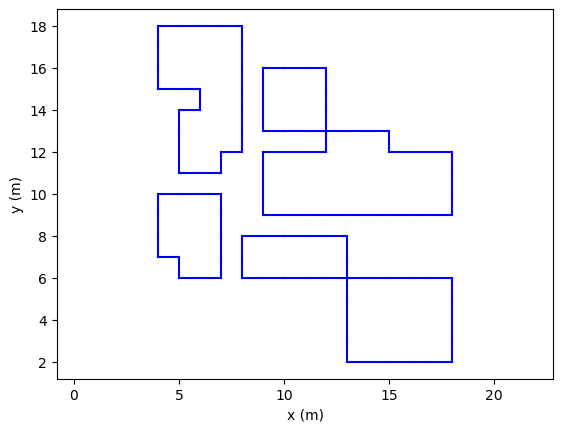

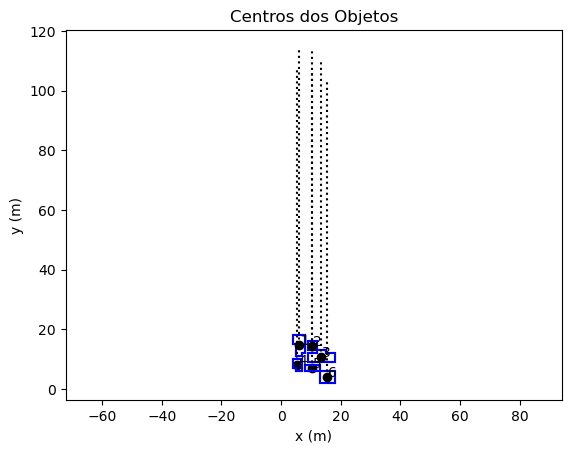

In [212]:
# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 
polys = []

# Encontrar e adicionar os pontos de contorno
for r in range(rows):
    for c in range(cols):
        if is_contour_cell(r, c, grid):
            add_contour_points(r, c, polys)

            
# Converte os pontos de contorno em polígonos
polys = [polys[i:i+2] for i in range(0, len(polys), 2)]

polys = find_polygons(polys)

for p in polys: 
    print(p)

# Desenha os obstáculos
draw(polys)

# Crie um grafo de visibilidade
graph = vg.VisGraph()
graph.build(polys)

centers = h.findCenters(polys)
#centers = [calculate_centroid(poly) for poly in polys]

plt.figure(2)
plt.title("Centros dos Objetos")
draw(polys, centers)

# Removendo células que estão em células marcadas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1: 
            # Adiciona as células ocupadas como polígonos (um quadrado por célula)
            '''polys.append([
                vg.Point(c * cell_size, map_dims[0] - r * cell_size),
                vg.Point(c * cell_size, map_dims[0] - (r + 1) * cell_size),
                vg.Point((c + 1) * cell_size, map_dims[0] - (r + 1) * cell_size),
                vg.Point((c + 1) * cell_size, map_dims[0] - r * cell_size)
            ])'''
            G.remove_node((r, c))

# Encontre o caminho mais curto entre dois pontos
start = vg.Point(0, 0)
end = vg.Point(40, 40)
path = graph.shortest_path(start, end)

# Desenhe o caminho mais curto
for i in range(len(path)):
    x1, y1 = path[i].x, path[i].y
    x2, y2 = path[(i + 1) % len(path)].x, path[(i + 1) % len(path)].y
    ax.plot([x1, x2], [y1, y2], 'g-')
    
# Plotando o Grid
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

# Vértices de início e fim
start = (0,0)
end = (rows-1, cols-1)
print("Start:", start)
print("End:", end)

100%|██████████| 16/16 [00:01<00:00, 12.14it/s]


Visibility Graph:


C:\Users\felip\AppData\Local\Temp\ipykernel_18244\3042003421.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.ginput()


[]

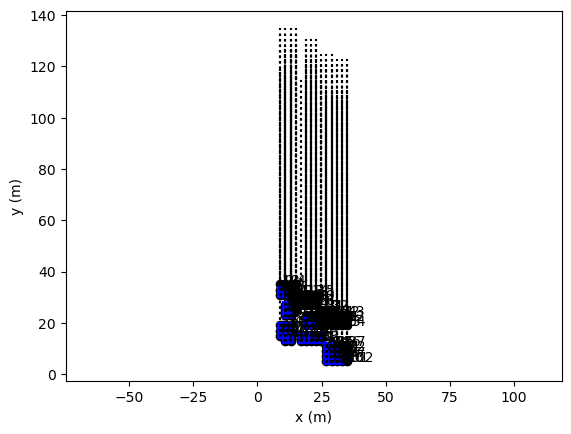

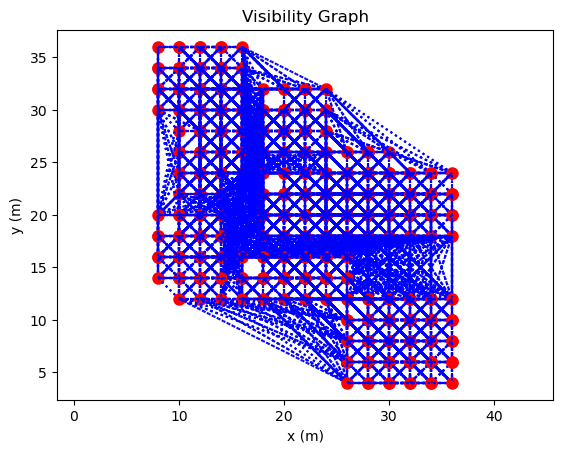

In [114]:
centers = h.findCenters(polys)

plt.figure(2)
draw(polys, centers)	

# Create the visibility graph
g = vg.VisGraph()  # This is the visibility graph
g.build(polys)

	
# Plot the visibility graph
plt.figure(1)
print("Visibility Graph:")
for poly in polys: # Para cada polígono na lista de obstáculos
    for vertex in poly: # Para cada vértice no polígono
        for edge in g.visgraph[vertex]: # Para cada aresta no grafo de visibilidade
            adj = edge.get_adjacent(vertex) # Vértice adjacente
            plt.plot([vertex.x, adj.x], [vertex.y, adj.y], 'b:') # Plota a aresta
        plt.plot(vertex.x, vertex.y, 'ro', markersize=8) # Plota o vértice
        
plt.axis('equal')
plt.title("Visibility Graph")
#plt.axis([-10, 10, -10, 10])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ginput()
 

#### Determinando o melhor caminho

End node: (18, 18)
Path: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (18, 12), (18, 13), (18, 14), (18, 15), (18, 16), (18, 17), (18, 18)]
Path length: 34


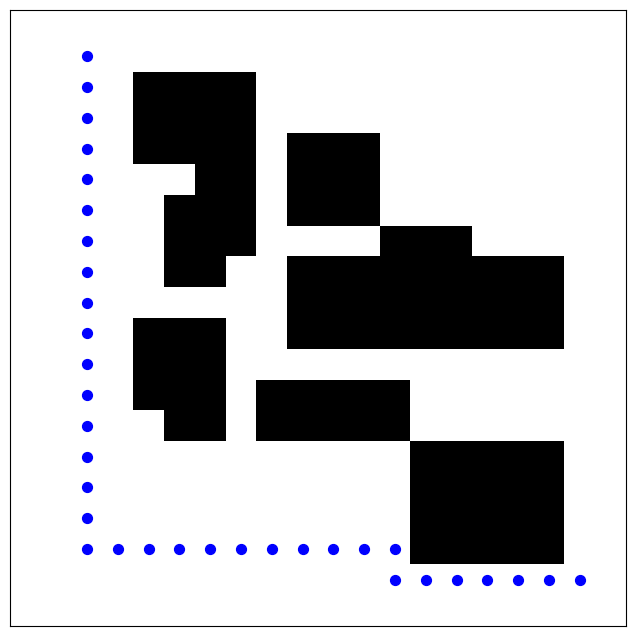

In [13]:
# Cave
start_node =  (1, 2)
# gerar um valor aleatório para o end_node que esteja dentro do grid e não seja um obstáculo
if grid[r][c] != 1: 
    end_node = (random.randint(0, rows-1), random.randint(0, cols-1))
print("End node:", end_node)

#end_node = (17, 18) # Goal 1

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=50, node_color='b')

print("Path:", path)
#prntar o número de posições no path
print("Path length:", len(path))

#### Convertendo para os referenciais da cena

Coppelia Path length: 34
Coppelia Path: [[-7.5  8.5]
 [-7.5  7.5]
 [-7.5  6.5]
 [-7.5  5.5]
 [-7.5  4.5]
 [-7.5  3.5]
 [-7.5  2.5]
 [-7.5  1.5]
 [-7.5  0.5]
 [-7.5 -0.5]
 [-7.5 -1.5]
 [-7.5 -2.5]
 [-7.5 -3.5]
 [-7.5 -4.5]
 [-7.5 -5.5]
 [-7.5 -6.5]
 [-7.5 -7.5]
 [-6.5 -7.5]
 [-5.5 -7.5]
 [-4.5 -7.5]
 [-3.5 -7.5]
 [-2.5 -7.5]
 [-1.5 -7.5]
 [-0.5 -7.5]
 [ 0.5 -7.5]
 [ 1.5 -7.5]
 [ 2.5 -7.5]
 [ 2.5 -8.5]
 [ 3.5 -8.5]
 [ 4.5 -8.5]
 [ 5.5 -8.5]
 [ 6.5 -8.5]
 [ 7.5 -8.5]
 [ 8.5 -8.5]]
Goal ->  [37. 37.]
Goal Coppelia ->  [ 8.5 -8.5]


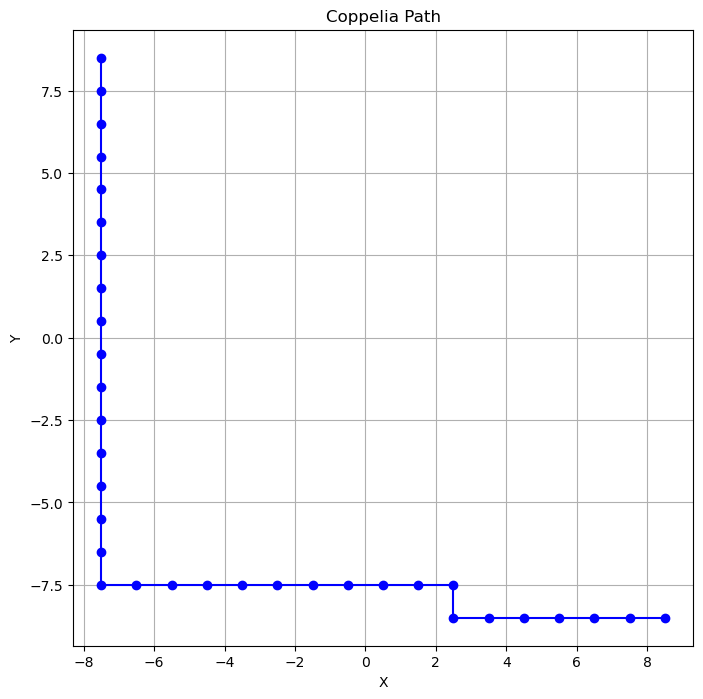

In [14]:
# Convertendo para os referenciais da cena
path = np.asarray(path) # Convertendo para array numpy
#print("Path cru: ",path)
path[:, [1, 0]] = path[:, [0, 1]] # invertendo os eixos porque no mapa utilizamos os nós invertidos.
path = path * cell_size + cell_size/2 # Convertendo para metros e adicionando o deslocamento para o centro da célula


coppeliaPath = [20, 20] - path
for i in range(len(coppeliaPath)):
    coppeliaPath[i, 0] = (coppeliaPath[i, 0] * (-1))/2
    coppeliaPath[i, 1] = (coppeliaPath[i, 1])/2

print("Coppelia Path length:", len(coppeliaPath))
print("Coppelia Path:", coppeliaPath)

#printar a última posição do array de path
print("Goal -> ", path[-1])
print("Goal Coppelia -> ", coppeliaPath[-1])

# Plotando o caminho do coppelia
plt.figure(figsize=(8, 8))
plt.plot(coppeliaPath[:, 0], coppeliaPath[:, 1], marker='o', color='b')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Coppelia Path')
plt.grid(False)
plt.show() 
    

## Movimentação do robô

In [15]:
# Conectando-se ao CoppeliaSim
# Run a simulation in asynchronous mode:
clientID = sim.startSimulation()


if clientID != -1:
    print("Connected to remote API server")

    # Get the robot's handle
    robotino = sim.getObjectHandle('/robotino')

    # Get the robot's wheels
    wheel1 = sim.getObjectHandle('wheel0_joint')
    wheel2 = sim.getObjectHandle('wheel1_joint')
    wheel3 = sim.getObjectHandle('wheel2_joint')

    # Retirado da aula 07 de navegação 
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
                       
    ganho = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]]) # Ganho do controlador

    # Adicione a coordenada Z se necessário (dependendo da sua aplicação)
    coppeliaPath = np.column_stack((coppeliaPath, np.zeros(len(coppeliaPath))))

for i in range(len(coppeliaPath)):
    # Posição do Robotino
    print("Goal: ", coppeliaPath[-1])

    while True:
        # Posição inicial do Robotino em cena
        robotinoPos = get_object_position(sim, '/robotino')  #start
        robotinoOri = get_object_orientation(sim, '/robotino')
        
        q_robot = np.array([robotinoPos[0], robotinoPos[1], robotinoOri[2]])

        # Calcule o erro entre a posição atual e o próximo ponto do caminho
        error = coppeliaPath[i] - q_robot
        errorNorm = np.linalg.norm(error[:2])

        print("Coppelia: ", q_robot)

        if errorNorm < 0.05:
            print("Goal reached")
            break

        # Calcule o vetor de controle usando o ganho e o erro
        qdot = ganho @ error

        # Calculando a velocidade linear e angular
        Minv = np.linalg.inv(Rz(q_robot[2]) @ Mdir)
        u = Minv @ qdot

        # Enviando velocidades para as rodas
        sim.setJointTargetVelocity(wheel1, 10 * u[0])
        sim.setJointTargetVelocity(wheel2, 10 * u[1])
        sim.setJointTargetVelocity(wheel3, 10 * u[2])

        # Atualizando a posição e orientação do robô
        robotinoPos = sim.getObjectPosition(robotino, -1)
        robotinoOri = sim.getObjectOrientation(robotino, -1)

    # Parando as rodas
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)

pos = sim.getObjectPosition(robotino, -1)
print(pos)

# Stop the simulation:
sim.stopSimulation()

Connected to remote API server
Goal:  [ 8.5 -8.5  0. ]
Coppelia:  [-6.99408366e+00  8.99658643e+00  6.68976355e-03]
Coppelia:  [-6.97003125  8.98092578  0.02615866]
Coppelia:  [-6.96972091  8.94398907  0.0713825 ]
Coppelia:  [-6.99603253  8.90574641  0.11944407]
Coppelia:  [-7.05597142  8.84326695  0.17822749]
Coppelia:  [-7.1088739   8.79538397  0.2480234 ]
Coppelia:  [-7.15836163  8.7523002   0.27561422]
Coppelia:  [-7.22105381  8.70498795  0.27811373]
Coppelia:  [-7.26474584  8.67399883  0.25567436]
Coppelia:  [-7.29088758  8.65568103  0.22920712]
Coppelia:  [-7.31339057  8.63988047  0.19129806]
Coppelia:  [-7.34350919  8.6181223   0.15602302]
Coppelia:  [-7.37047006  8.59887237  0.12831849]
Coppelia:  [-7.40600616  8.57308136  0.09248175]
Coppelia:  [-7.43519216  8.55179468  0.06274856]
Coppelia:  [-7.44675593  8.54300802  0.04581641]
Coppelia:  [-7.45914925  8.53335482  0.03514952]
Coppelia:  [-7.46578734  8.52781329  0.02767276]
Goal reached
Goal:  [ 8.5 -8.5  0. ]
Coppelia:  [-7